In [1]:
import pandas as pd

from features import Featured

people = pd.read_csv("../datasets/brazilian_names.csv")

df = pd.DataFrame(map(Featured.from_row, people.to_dict(orient="records")))

In [2]:
# plano de emergência: explodir coluna de sílabas normalizadas e gerar decisões a partir delas
exploded_sylables = (
    df.explode("normalized_syllables", ignore_index=True)
    .rename(columns={"normalized_syllables": "syllable"})
    .drop(columns=["syllables"])
)

# feature para caracteres e fonemas estrangeiros? ki, sh, y
df.loc[(df["gender"] == "F") & (df["ends_in_vowel"] == False)]

,syllables,normalized_syllables,ends_in_vowel,ending_vowel,ending_consonant,starts_in_vowel,starting_vowel,starting_consonant,nasal_count,sharp_count,a_count,i_count,u_count,e_count,o_count,rome_r_count,potato_r_count,laughed_r_count,s_count,gender
55,"[yas, min]","[yas, min]",False,i,n,True,y,None,0,0,1,1,0,0,0,0,0,0,0,F
93,"[be, a, triz]","[be, a, triz]",False,i,z,False,e,b,2,1,1,1,0,1,0,1,0,0,0,F
133,"[sa, rah]","[sa, rah]",False,a,h,False,a,s,0,0,2,0,0,0,0,1,0,0,1,F
139,"[li, li, an]","[li, li, an]",False,a,n,False,i,l,0,0,1,2,0,0,0,0,0,0,0,F
159,"[ra, quel]","[ra, quel]",False,e,l,False,a,r,0,1,1,0,1,1,0,0,0,1,0,F
183,"[be, a, triz]","[be, a, triz]",False,i,z,False,e,b,2,1,1,1,0,1,0,1,0,0,0,F
235,"[ra, quel]","[ra, quel]",False,e,l,False,a,r,0,1,1,0,1,1,0,0,0,1,0,F
341,"[i, sa, bel]","[i, sa, bel]",False,e,l,True,i,None,2,0,1,1,0,1,0,0,0,0,0,F
351,"[e, ve, lyn]","[e, ve, lyn]",False,y,n,True,e,None,1,0,0,0,0,2,0,0,0,0,0,F
369,"[ra, quel]","[ra, quel]",False,e,l,False,a,r,0,1,1,0,1,1,0,0,0,1,0,F


In [3]:
from sklearn.preprocessing import OneHotEncoder

original_cols = ["ending_vowel", "ending_consonant"]
encoder_vowels = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
hot_ending_arr = encoder_vowels.fit_transform(df[original_cols])
hot_ending_df = pd.DataFrame(
    hot_ending_arr, columns=encoder_vowels.get_feature_names_out(original_cols)
).astype(bool)

df = pd.concat([df, hot_ending_df], axis=1).drop(columns=original_cols)
hot_ending_df.head(10)

,ending_vowel_a,ending_vowel_e,ending_vowel_i,ending_vowel_o,ending_vowel_u,ending_vowel_y,ending_vowel_None,ending_consonant_d,ending_consonant_h,ending_consonant_l,ending_consonant_m,ending_consonant_n,ending_consonant_r,ending_consonant_s,ending_consonant_x,ending_consonant_z,ending_consonant_None
0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
2,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True
3,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True
4,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
5,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
6,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True
7,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True
8,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
9,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


In [4]:
from typing import Any, Hashable


def partition(
    rows: pd.DataFrame, column: Hashable, breakpoint: Any
) -> tuple[pd.DataFrame, pd.DataFrame]:
    if isinstance(breakpoint, int | float):
        groups = rows.groupby(rows[column].apply(lambda n: n >= breakpoint))
    else:
        groups = rows.groupby(rows[column].apply(lambda n: n == breakpoint))

    if groups.groups.get(False) is None:
        return groups.get_group(True), pd.DataFrame({column: []})
    if groups.groups.get(True) is None:
        return pd.DataFrame({column: []}), groups.get_group(False)

    return groups.get_group(True), groups.get_group(False)


def gini(rows: pd.DataFrame, target: str) -> float:
    return 1 - sum(rows[target].value_counts(normalize=True) ** 2)


def find_best_split(rows: pd.DataFrame, target: str) -> tuple[Hashable, Any]:
    best = (0, "", None)  # gain, column, breakpoint
    uncertainty = gini(rows, target)

    for col, values in rows.items():
        if col == target:
            continue

        for val in values.unique():
            left, right = partition(rows, col, val)
            if len(left) == 0 or len(right) == 0:
                continue

            p = len(left) / (len(left) + len(right))
            gain = uncertainty - p * gini(left, target) - (1 - p) * gini(right, target)

            if gain > best[0]:
                best = (gain, col, val)

    return best[1], best[2]

In [5]:
df.drop(columns=["syllables", "normalized_syllables"], inplace=True)

split_col, split_break = find_best_split(df, "gender")

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
left, right = partition(df, split_col, split_break)

left_split_col, left_split_break = find_best_split(left, "gender")
right_split_col, right_split_break = find_best_split(right, "gender")

left_left, left_right = partition(left, left_split_col, left_split_break)
right_left, right_right = partition(right, right_split_col, right_split_break)

left_left["leaf_bin"] = f"{split_col}\n{left_split_col}"
left_right["leaf_bin"] = f"{split_col}\n!{left_split_col}"
right_left["leaf_bin"] = f"!{split_col}\n{right_split_col}"
right_right["leaf_bin"] = f"!{split_col}\n!{right_split_col}"

df = pd.concat(
    [left_left, left_right, right_left, right_right], ignore_index=True
)

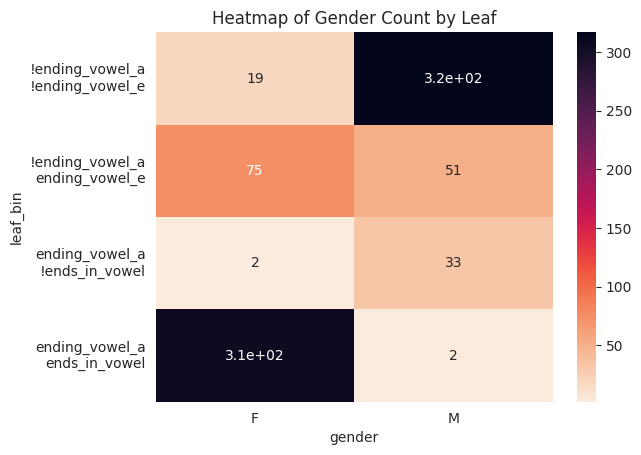

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
pivot = df.pivot_table(
    index="leaf_bin", columns="gender", aggfunc="size", fill_value=0
)
sns.heatmap(pivot, annot=True, cmap="rocket_r")
plt.title("Heatmap of Gender Count by Leaf")
plt.show()